## Project description

Prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry.

The model should predict the amount of gold recovered from gold ore. You have the data on extraction and purification.

The model will help to optimize the production and eliminate unprofitable parameters.

The data is stored in three files:

* gold_recovery_train.csv — training dataset download
* gold_recovery_test.csv — test dataset download
* gold_recovery_full.csv — source dataset download

Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar.

Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.
The source dataset contains the training and test sets with all the features.

## Initialization

In [1]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

# model creation

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

In [2]:
# import data

gold_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
gold_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [4]:
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [5]:
gold_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


The test set has 34 fewer items than the training set. The ones we are interested in as our targets are rougher.output.recovery and final.output.recovery.

### Recovery check

We should be able to get an examination of if the rougher is calculated correctly by going for a manual calculation and comparing to the one in the full set and check our mean absolute error. First, we can get a look at the descriptive statistics of our data to get a handle on what we should expect to see from our manual calculation.

In [6]:
gold_full['rougher.output.recovery'].describe()

count    19597.000000
mean        83.078122
std         14.661880
min          0.000000
25%         80.941306
50%         86.144121
75%         89.987561
max        100.000000
Name: rougher.output.recovery, dtype: float64

The formula to calculate the recovery is as follows:

$$ R = \frac{C * (F - T)}{F * (C - T)} * 100$$

C = rougher.output.concentrate_au

F = rougher.input.feed_au

T = rougher.output.tail_au

In [7]:
def test_rough(gold):
    # set variables

    # C is the share of gold AFTER flotation

    C = gold['rougher.output.concentrate_au']

    # F is the share of gold BEFORE the flotation

    F = gold['rougher.input.feed_au']

    # T is the share of gold in the tails BEFORE flotation

    T = gold['rougher.output.tail_au']
    
    # calculate
    
    try:
        test_rougher = ((C * (F - T)) / (F * (C - T))) * 100
        return test_rougher
    except ZeroDivisionError:
        return 0

true_rougher = gold_full['rougher.output.recovery']

test_rougher = test_rough(gold_full)

test_rougher.describe()

count    1.994000e+04
mean              NaN
std               NaN
min              -inf
25%      8.078582e+01
50%      8.612560e+01
75%      9.003910e+01
max               inf
dtype: float64

Here we see that the test_rougher has some values that are giving us NaN, which will mess with possible calculations. The reason for this is because there are values that are dividing by zero since F has some values that are zero. If there's no gold in the feed before flotation, then it goes to follow that there will be no gold in the feed after the flotation and thus, the value will be zero.

To solve this, we will set any results that are less than 0 to 0, and any results greater than 100 to 100.

In [8]:
test_rougher = np.clip(test_rougher, 0, 100)
test_rougher.describe()

count    19940.000000
mean        82.391272
std         16.745940
min          0.000000
25%         80.785821
50%         86.125595
75%         90.039104
max        100.000000
dtype: float64

In [9]:
true_rougher.describe()

count    19597.000000
mean        83.078122
std         14.661880
min          0.000000
25%         80.941306
50%         86.144121
75%         89.987561
max        100.000000
Name: rougher.output.recovery, dtype: float64

With this done, we can check the mean absolute error safely. We do still have some values that have missing values in both sets of data. We will fill those in with a value of 0 - this may seem slightly reckless as we don't know whether or not the value actually is zero, but actually this should be fine. It will make our MAE lean closer to being "too strict."

In [10]:
# find mae

mean_absolute_error(true_rougher.fillna(0), test_rougher.fillna(0))

0.6515231554851291

Our mean absolute error is 0.6515, a fairly respectable number. We are dealing with percentages here, after all, so this would indicate that compared to a manually calculated value, the results we are seeing in the data set are on average only a little over one half of one percent off, being as strict as possible. 

### Features not available in test set

As could be seen in some of our preliminary looks, the test set is missing exactly 34 columns from the full set of data - meaning it has 52 columns or 51 potential features compared to the 86 columns (85 potential features) of the full data. The following columns are ones that are not found in gold_test.

In [11]:
gold_full[gold_full.columns[~gold_full.columns.isin(gold_test.columns)]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 non-null  float64
 8   final.output.tail_au                                22635 non-null  float64


One thing we can note here is that all of the missing values present are those of outputs or calculations dependent on those outputs. This should be fine, since we are aiming to build a model that will predict those values.

Since these are values that are in the training set but not the test set, we should remove the columns in question from our training set, so that we are building a model that we can apply to the test set.

### Data preprocessing

We have a few things we might want to do in our data preprocessing. Firstly, we want to get rid of missing values if possible. We will use ffill in order to do this.

In [12]:
# fill null values
gold_full.fillna(method='ffill', inplace=True)

gold_train.fillna(method='ffill', inplace=True)

gold_test.fillna(method='ffill', inplace=True)

Next, we should create a training and test set for our data. We will drop the columns that are not inside the test set from the training set, so that they will not be likely to influence our results.

In [13]:
unalike_columns = ['final.output.concentrate_ag', 
                   'final.output.concentrate_pb', 
                   'final.output.concentrate_sol', 
                   'final.output.concentrate_au', 
                   'final.output.tail_ag', 
                   'final.output.tail_pb',
                   'final.output.tail_sol', 
                   'final.output.tail_au', 
                   'primary_cleaner.output.concentrate_ag',
                   'primary_cleaner.output.concentrate_pb', 
                   'primary_cleaner.output.concentrate_sol', 
                   'primary_cleaner.output.concentrate_au', 
                   'primary_cleaner.output.tail_ag', 
                   'primary_cleaner.output.tail_pb', 
                   'primary_cleaner.output.tail_sol', 
                   'primary_cleaner.output.tail_au', 
                   'rougher.calculation.sulfate_to_au_concentrate', 
                   'rougher.calculation.floatbank10_sulfate_to_au_feed', 
                   'rougher.calculation.floatbank11_sulfate_to_au_feed', 
                   'rougher.calculation.au_pb_ratio', 
                   'rougher.output.concentrate_ag', 
                   'rougher.output.concentrate_pb', 
                   'rougher.output.concentrate_sol', 
                   'rougher.output.concentrate_au', 
                   'rougher.output.tail_ag', 
                   'rougher.output.tail_pb', 
                   'rougher.output.tail_sol', 
                   'rougher.output.tail_au', 
                   'secondary_cleaner.output.tail_ag', 
                   'secondary_cleaner.output.tail_pb', 
                   'secondary_cleaner.output.tail_sol', 
                   'secondary_cleaner.output.tail_au', 
                   'date']

# drop features from training set

gold_train_b = gold_train.drop(unalike_columns, axis = 1)

# split into features/target

features_train = gold_train_b.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)
target_train = gold_train_b[['rougher.output.recovery', 'final.output.recovery']]

Since our test data set did not include the final.output.recovery and rougher.output.recovery targets, we should add them in by performing a left merge with the full data set. In this case, we can merge on the date to ensure that the correct data is imported.

In [14]:
# merge recovery into gold_test

gold_test_b = pd.merge(gold_test, gold_full[['date', 'final.output.recovery', 'rougher.output.recovery']], 
                       on = 'date', how = 'left')

# drop date

gold_test_b = gold_test_b.drop(['date'], axis = 1)

# split into features/target

features_test = gold_test_b.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)
target_test = gold_test_b[['rougher.output.recovery', 'final.output.recovery']]

## Data analysis

### Concentration of metals based on purification stage

Since we are mainly just taking note of how the concentrations change, we will do some fairly rudimentary analysis based on the stages and if anything seems odd we will investigate further. Since we need to repeat our visualization for multiple different metals, we can create a function to keep this section cleaner.

Starting with the concentration of gold, as that is the most important one to look into.

In [15]:
def visualize_metals(metal):
    print('Sum\n',metal.sum(), '\n')
    print('Descriptive stats:\n', metal.describe())
    metal.plot(kind = 'hist', bins = 50, title = 'metal ratio based on stage', xlabel = 'percent', density = True,
               alpha = 0.25, grid = True, figsize = (15,8))

In [16]:
au_concentrations = gold_full[['rougher.input.feed_au', 'rougher.output.concentrate_au', 
                               'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]

Sum
 rougher.input.feed_au                    171411.780412
rougher.output.concentrate_au            405060.555729
primary_cleaner.output.concentrate_au    661489.159778
final.output.concentrate_au              906180.262071
dtype: float64 

Descriptive stats:
        rougher.input.feed_au  rougher.output.concentrate_au  \
count           22716.000000                   22716.000000   
mean                7.545861                      17.831509   
std                 3.047761                       6.842737   
min                 0.000000                       0.000000   
25%                 6.473371                      17.894015   
50%                 7.879193                      19.995513   
75%                 9.664583                      21.562366   
max                14.093363                      28.824507   

       primary_cleaner.output.concentrate_au  final.output.concentrate_au  
count                           22716.000000                 22716.000000  
mean              

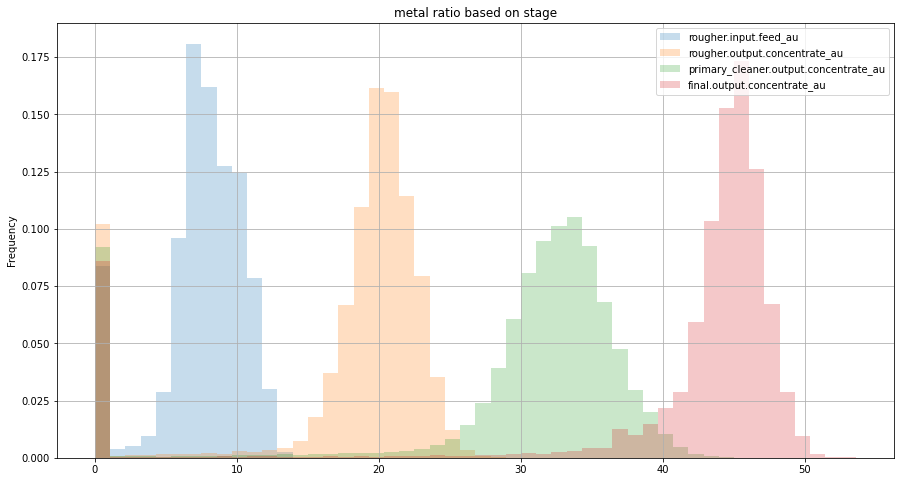

In [17]:
visualize_metals(au_concentrations)

As we could have expected, the average concentration of gold increases in each of our stages and the frequency of 0 concentration lowers.

In [18]:
ag_concentrations = gold_full[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 
                               'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]

Sum
 rougher.input.feed_ag                    182732.898021
rougher.output.concentrate_ag            246368.863860
primary_cleaner.output.concentrate_ag    174162.930712
final.output.concentrate_ag              108310.180492
dtype: float64 

Descriptive stats:
        rougher.input.feed_ag  rougher.output.concentrate_ag  \
count           22716.000000                   22716.000000   
mean                8.044237                      10.845609   
std                 3.148133                       4.406924   
min                 0.000000                       0.000000   
25%                 6.935723                      10.112351   
50%                 8.295898                      11.774115   
75%                10.127434                      13.609712   
max                14.869652                      24.480271   

       primary_cleaner.output.concentrate_ag  final.output.concentrate_ag  
count                           22716.000000                 22716.000000  
mean              

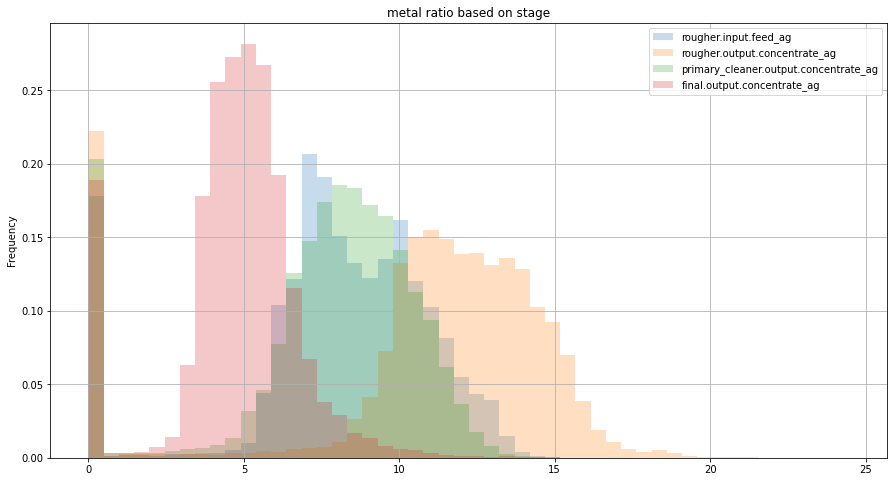

In [19]:
visualize_metals(ag_concentrations)

In [20]:
pb_concentrations = gold_full[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 
                               'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]

Sum
 rougher.input.feed_pb                     74575.380942
rougher.output.concentrate_pb            156442.126750
primary_cleaner.output.concentrate_pb    200110.183752
final.output.concentrate_pb              206065.154798
dtype: float64 

Descriptive stats:
        rougher.input.feed_pb  rougher.output.concentrate_pb  \
count           22716.000000                   22716.000000   
mean                3.282945                       6.886869   
std                 1.462554                       2.831347   
min                 0.000000                       0.000000   
25%                 2.634169                       6.366740   
50%                 3.419915                       7.570890   
75%                 4.199225                       8.477617   
max                 7.142594                      18.394042   

       primary_cleaner.output.concentrate_pb  final.output.concentrate_pb  
count                           22716.000000                 22716.000000  
mean              

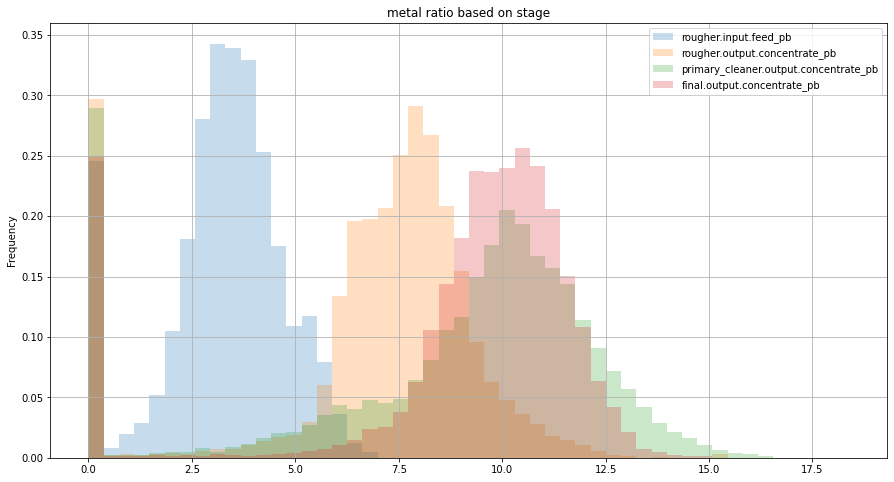

In [21]:
visualize_metals(pb_concentrations)

The concentration of gold went up as we progressed through the stages, which makes sense as that is what the process is meant to do. It appears to become approximately 15% more concentrated each stage on average. Our silver concentration drops as the stages progress, which also makes sense since proportionally we would expect that, as the ratio of gold rises that we would see the ratio of other metals to drop.

The lead ratio is interesting, however, in that its concentration also rises, which suggests that the metals we are losing in the flotation and purification process are silver and sol. When we consider that this change occurs during the flotation stage and that the ratio remains fairly consistent afterwards, it is likely that if we wished to alter the results, this would be the stage to look into.

### Feed particle size distribution

We need to compare the data of our feed particle size distributions to ensure that the distributions are similar in size, since if they are too different then the model evaluation will be incorrect.

Training:
 count    16860.000000
mean         7.297285
std          0.619166
min          1.080000
25%          6.940000
50%          7.285000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

Test:
 count    5856.000000
mean        7.264651
std         0.611526
min         5.650000
25%         6.885625
50%         7.259333
75%         7.650000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64


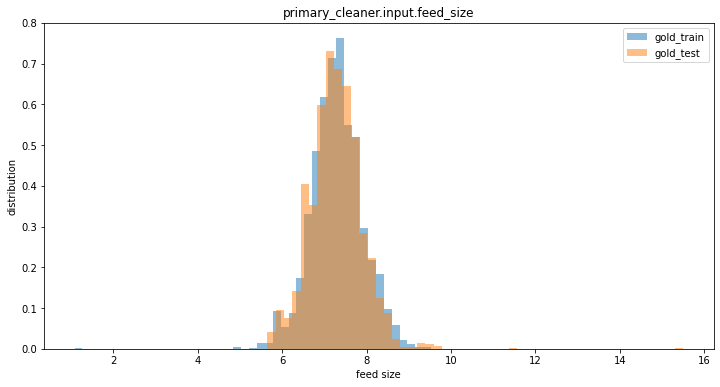

In [22]:
# descriptive stats

print("Training:\n", gold_train['primary_cleaner.input.feed_size'].describe())
print("\nTest:\n", gold_test['primary_cleaner.input.feed_size'].describe())

# histogram

plt.figure(figsize=(12, 6))
plt.hist(gold_train['primary_cleaner.input.feed_size'], density = True, alpha = 0.5, bins = 50)
plt.hist(gold_test["primary_cleaner.input.feed_size"], density = True, alpha = 0.5, bins = 50)
plt.title('primary_cleaner.input.feed_size')
plt.xlabel('feed size')
plt.ylabel('distribution')
plt.legend(['gold_train', 'gold_test'])
plt.show()

Training:
 count    16860.000000
mean        60.188595
std         30.522242
min          9.659576
25%         47.548897
50%         54.066003
75%         65.397249
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Test:
 count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64


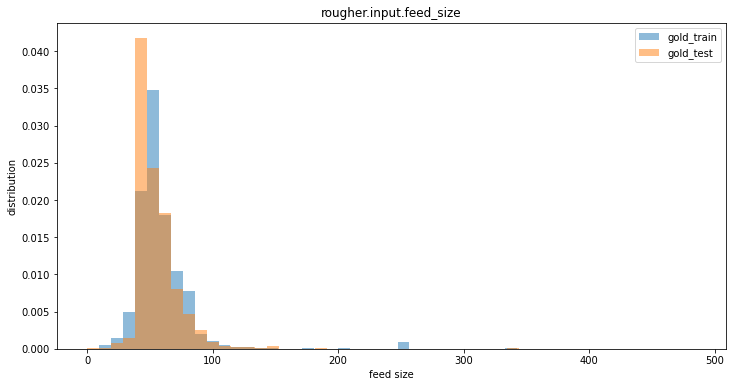

In [23]:
# descriptive stats

print("Training:\n", gold_train['rougher.input.feed_size'].describe())
print("\nTest:\n", gold_test['rougher.input.feed_size'].describe())

# histogram

plt.figure(figsize=(12, 6))
plt.hist(gold_train['rougher.input.feed_size'], density = True, alpha = 0.5, bins = 50)
plt.hist(gold_test["rougher.input.feed_size"], density = True, alpha = 0.5, bins = 50)
plt.title('rougher.input.feed_size')
plt.xlabel('feed size')
plt.ylabel('distribution')
plt.legend(['gold_train', 'gold_test'])
plt.show()

Some of these items look to be fairly close, and others slightly less so. There is no clear discrepancy, the distributions both appear to be normal around the same general area.

### Concentrations of substances at different stages

In [24]:
feed_total = (gold_full['rougher.input.feed_au'] + gold_full['rougher.input.feed_ag']
                 + gold_full['rougher.input.feed_pb'] + gold_full['rougher.input.feed_sol'])
rougher_total = (gold_full['rougher.output.concentrate_au'] + gold_full['rougher.output.concentrate_ag']
                 + gold_full['rougher.output.concentrate_pb'] + gold_full['rougher.output.concentrate_sol'])
final_total = (gold_full['final.output.concentrate_au'] + gold_full['final.output.concentrate_ag']
                 + gold_full['final.output.concentrate_pb'] + gold_full['final.output.concentrate_sol'])

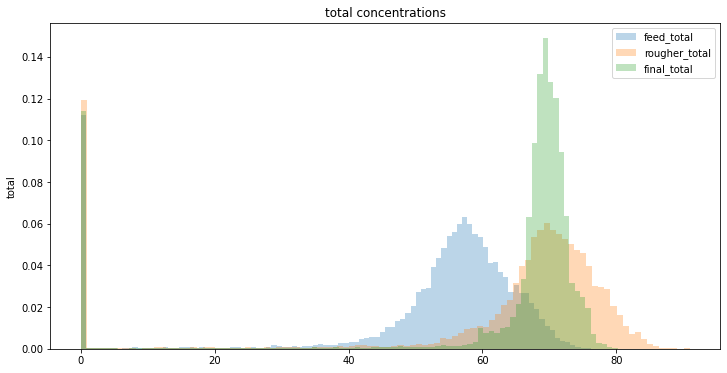

In [25]:
plt.figure(figsize=(12, 6))
plt.hist(feed_total, density = True, alpha = 0.3, bins = 100)
plt.hist(rougher_total, density = True, alpha = 0.3, bins = 100)
plt.hist(final_total, density = True, alpha = 0.3, bins = 100)
plt.title('total concentrations')
plt.ylabel('total')
plt.legend(['feed_total', 'rougher_total', 'final_total'])
plt.show()

The concentration of all our metals is, as we might hope, highest on average in our final results. Though it appears that there are some instances of higher value in the rougher.

We could have seen it in some of our earlier plots but we also see a pretty large gathering where the total concentration of metals is 0 across all three stages, or at least very close to 0. This would suggest it's a sample that has practically none of the substances we wish to use for profit in question from the outset - so, if we aim to analyze the process of purification, we might wish to get rid of those samples that have never had any of our substances from the beginning.

First, we can check and see just what proportion of our data these low values are encompassing.

In [26]:
(gold_full[(gold_full['final.output.concentrate_ag'] + gold_full['final.output.concentrate_au'] +
            gold_full['final.output.concentrate_pb'] + gold_full['final.output.concentrate_sol'])
           <= 1]).count() / len(gold_full)

date                                          0.091653
final.output.concentrate_ag                   0.091653
final.output.concentrate_pb                   0.091653
final.output.concentrate_sol                  0.091653
final.output.concentrate_au                   0.091653
                                                ...   
secondary_cleaner.state.floatbank5_a_level    0.091653
secondary_cleaner.state.floatbank5_b_air      0.091653
secondary_cleaner.state.floatbank5_b_level    0.091653
secondary_cleaner.state.floatbank6_a_air      0.091653
secondary_cleaner.state.floatbank6_a_level    0.091653
Length: 87, dtype: float64

We see that about 9.1653% of our data set is these values lower than 1. In terms of training our data, this probably is too much to exclude from our data set. Not including the data could harm the model more than it helps.

On the other hand, it seems like it could very well be data that has some sort of error with it, and that if we do not drop it that it could introduce data into our model that should not be there. Since it is unclear what is causing these strange observations and they may be related to an error in the data collection process, it likely would be for the best that we remove them.

In [27]:
# create copy data frame

gold_train_c = gold_train.copy(deep = False)

# add an all concentration column

gold_train_c['all_concentration'] = (gold_train_c['final.output.concentrate_ag'] + gold_train_c['final.output.concentrate_au'] +
            gold_train_c['final.output.concentrate_pb'] + gold_train_c['final.output.concentrate_sol'])

# remove rows where all concentration is 0

gold_train_c = gold_train_c[gold_train_c['all_concentration'] > 0]

# since we have needed data that we originally dropped from our training set in preprocessing,
# we will need to remake our training set

gold_train_d = gold_train_c.drop(unalike_columns, axis = 1)
gold_train_d = gold_train_d.drop(['all_concentration'], axis = 1)

features_train = gold_train_d.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)
target_train = gold_train_d[['rougher.output.recovery', 'final.output.recovery']]

We will also need to redo our preprocessing that we did on the test set to remove these rows.

In [28]:
# merge recovery into gold_test

gold_test_c = pd.merge(gold_test, gold_full[['date', 'final.output.recovery', 'rougher.output.recovery', 
                                             'final.output.concentrate_ag', 'final.output.concentrate_au',
                                             'final.output.concentrate_pb', 'final.output.concentrate_sol']], 
                       on = 'date', how = 'left')

# add all concentration

gold_test_c['all_concentration'] = (gold_test_c['final.output.concentrate_ag'] + gold_test_c['final.output.concentrate_au'] +
            gold_test_c['final.output.concentrate_pb'] + gold_test_c['final.output.concentrate_sol'])

# remove rows where all concentration is 0

gold_train_c = gold_train_c[gold_train_c['all_concentration'] > 0]

# drop columns used for calculation

gold_test_c = gold_test_c.drop(['date', 'all_concentration', 'final.output.concentrate_ag', 'final.output.concentrate_au',
                                'final.output.concentrate_pb', 'final.output.concentrate_sol'], axis = 1)

# split into features/target

features_test = gold_test_c.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)
target_test = gold_test_c[['rougher.output.recovery', 'final.output.recovery']]

## Build the model

To create the model, we can try a few different forms of regression. We'll want to use cross validation to train our models to get the highest accuracies. For this, it would be useful to make our cross validation be placed in its own function so that it can be run across different models.

### Final sMAPE function

Firstly, we will create a function that will let us take the final sMAPE. Our function will perform the following calculations:

$$sMAPE = \frac{1}{N} \Sigma^n_{i = 1} \frac{|y_i-\hat{y_i}|} {\frac{1}{2} (|y_i|-|\hat{y_i}|)} *100$$

$$sMAPE_{complete} = 0.25 * sMAPE_{rougher} + 0.75 * sMAPE_{final}$$

In [148]:
# calculate smape

def calc_smape(target, prediction):
    try:
        numerator = np.abs(prediction - target)
        denominator = 0.5 * (np.abs(target) + np.abs(prediction))
                        
        smape = 100/len(target) *  np.abs(np.sum(numerator / denominator))
        return smape
    except ZeroDivisionError:
        return 0

def final_smape(target, prediction):
    r_smape = calc_smape(target['rougher.output.recovery'], prediction[:,0])
    f_smape = calc_smape(target['final.output.recovery'], prediction[:,1])
    
    final_smape = (0.25 * r_smape) + (0.75 * f_smape)
    
    return final_smape

In [149]:
smape_scorer = make_scorer(final_smape, greater_is_better=False)

In [150]:
def get_cv_scores(model_type, feature, target):

    kfold = KFold(n_splits = 5, random_state = 12345, shuffle = True)

    cross_val_smape = np.abs(cross_val_score(model_type, feature, target, scoring = smape_scorer, cv = kfold))

    print("Cross-Validation sMAPE Scores:")
    print('Mean:', cross_val_smape.mean())
    print('Min:', cross_val_smape.min())
    print('Max:', cross_val_smape.max())

### Train different models

In [151]:
dec_tree = DecisionTreeRegressor(random_state = 12345)

print('Decision Tree model:')
get_cv_scores(dec_tree, features_train, target_train)

Decision Tree model:
Cross-Validation sMAPE Scores:
Mean: 8.923443253849005
Min: 8.480205504061184
Max: 9.344384233579696


In [152]:
lin_reg = LinearRegression()

print('Linear Regression model:')
get_cv_scores(lin_reg, features_train, target_train)

Linear Regression model:
Cross-Validation sMAPE Scores:
Mean: 10.796211479873815
Min: 10.54147011354803
Max: 11.051290612535444


In [167]:
ran_forest = RandomForestRegressor(random_state = 12345)

print('Random Forest model:')
get_cv_scores(ran_forest, features_train, target_train)

Random Forest model:
Cross-Validation sMAPE Scores:
Mean: 7.253623086262249
Min: 7.022530410998325
Max: 7.52781380317766


Thus far, our random forest is providing us with the most accurate model, with the lowest sMAPE. We should iterate on the model by tuning our hyperparameters.

#### Hyperparameter Tuning

In order to find the best set of hyperparameters possible, we will use a parameter grid from which we can test across many different hyperparameters. To get a good idea, we will create a hyperparameter tuning based on three predictors, two of which are granted five separate points and the third being the max_features parameter, which will grant us numerous fits of models to compare. We will ensure that default values are also possible, just to see if the default model might still be the best option.

In [159]:
# create the parameter grid

param_grid = {
    'max_depth': [1, 3, 5, 7, 11, 13, None],
    'min_samples_leaf': [1, 3, 5, 7, 11, 13],
    'max_features': ['auto', 'sqrt', 'log2']
}

model = RandomForestRegressor(random_state = 12345)

# set grid to model

grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                           scoring = smape_scorer, cv = 5, n_jobs = -1, verbose = 2)

In [160]:
# fit the grid to the data

grid_search.fit(features_train, target_train)
best_param = grid_search.best_params_

print("\n Best score:\n",
          grid_search.best_score_)
    
print("\n Best parameters:\n",
          grid_search.best_params_)

Fitting 5 folds for each of 126 candidates, totalling 630 fits
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=1; total time=   4.1s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=1; total time=   4.2s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=1; total time=   4.2s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=1; total time=   4.2s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=1; total time=   4.3s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=3; total time=   4.2s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=3; total time=   4.1s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=3; total time=   4.2s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=3; total time=   4.2s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=3; total time=   4.3s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=5; total time=   4.2s
[CV] END .max_depth=1, max_features=auto, min_

Our parameters for the best random forest model are: {'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 13} with a score of -11.0455. We will test our model with this tuning and recheck the cross-validated sMAPE score.

In [161]:
model = RandomForestRegressor(random_state = 12345, max_depth = 7, min_samples_leaf = 13, max_features = 'auto')
model.fit(features_train, target_train)
prediction = model.predict(features_test)

get_cv_scores(model, features_train, target_train)

Cross-Validation sMAPE Scores:
Mean: 9.39142997191798
Min: 9.26900019204873
Max: 9.54935309137293


Something that seems a bit strange here is that while we are picking what was calculated as a best model, the sMAPE scores look to be slightly higher than the default random forest model. This could be an issue, but one thing that could be important to note is that the minimum and maximum of this model are also closer together, which in terms of a predictive model could mean it is more reliable.

We will also test our model against some dummy models set to always predict the mean or median of the training set targets.

In [168]:
# create prediction for random forest

ran_forest.fit(features_train, target_train)
forest_predict = ran_forest.predict(features_test)

# create dummy models and predictions

mean_model = DummyRegressor(strategy = "mean")
mean_model.fit(features_train, target_train)
mean_predict = mean_model.predict(features_test)

median_model = DummyRegressor(strategy = "median")
median_model.fit(features_train, target_train)
median_predict = median_model.predict(features_test)

In [163]:
get_cv_scores(mean_model, features_train, target_train)

Cross-Validation sMAPE Scores:
Mean: 12.508660463725619
Min: 12.265751820289431
Max: 12.78794088473705


In [164]:
get_cv_scores(median_model, features_train, target_train)

Cross-Validation sMAPE Scores:
Mean: 12.326949229259514
Min: 12.059462092052428
Max: 12.61223233666702


In [169]:
# calculate smapes

smape = final_smape(target_test, prediction)
forest_smape = final_smape(target_test, forest_predict)
mean_smape = final_smape(target_test, mean_predict)
median_smape = final_smape(target_test, median_predict)

print('Final sMAPE score: ', smape)
print('Default random forest sMAPE score:', forest_smape)
print('Mean model sMAPE score: ', mean_smape)
print('Median model sMAPE score: ', median_smape)

Final sMAPE score:  12.817603159415423
Default random forest sMAPE score: 13.43566558089573
Mean model sMAPE score:  12.531788913477865
Median model sMAPE score:  11.922783858802665


The mean and median models have an overall lower sMAPE than our final model, but this may not necessarily be an issue, since we know from our earlier graphs how normally distributed our data is. The average models probably should be fairly accurate. The cross-validation of the sMAPE score also shows that the model is rather stable as well as being accurate. We can conclude that this model will be useful for predicting our output.

## Conclusion

To recap this project, first we analyzed the data:

* We have checked the concentration of metals across the purification and found that primarily, the gold concentration increases in the purification.

* We checked the feed particle size distribution and found that for the training and test set the data is distributed consistently.

* We checked the concentration of all the precious metals at different stages and discovered that the purification process causes them to increase.

Next, we constructed a model to calculate the final sMAPE value and generated a model, then tested that model to find our final sMAPE score.